In [1]:
import qctoolkit as qtk
from matplotlib import pyplot as plt
import numpy as np
from copy import deepcopy
import horton as ht
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import UnivariateSpline
from glob import glob
import os

#Note inline and notebook is contradicting to each other
%matplotlib notebook

missing file: mov2asc
please modify /path/to/qctoolkit/setting.py and recompile.


/home/samio/local/miniconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
qmsetting_test = {
    'program': 'horton',
    'basis_set': 'sto-3g',
    'theory': 'pbe',
    'threads': 1,
}

qmsetting_production = {
    'program': 'gaussian',
    'basis_set': 'cc-pVDZ',
    'theory': 'pbe',
    'threads': 1,
}

qmsetting_production_ccsd = {
    'program': 'gaussian',
    'basis_set': 'cc-pVDZ',
    'theory': 'ccsd',
    'threads': 1,
}

qmsetting_production_ccsdt = {
    'program': 'gaussian',
    'basis_set': 'cc-pVDZ',
    'theory': 'ccsd(t)',
    'threads': 1,
}

# Test runs
use small basis set and coarse distance scan for pipline testing and trend discovery
instead of the setting:
* cc-pVDZ
* for d in np.linspace(0.6, 2, 20)
* $\Delta Z$ = 1

test runs are done by
* sto-3g
* for d in np.linspace(0.6, 2, 5)
* $\Delta Z$ = 2

In [2]:
# # construct dataset

# Z_A = range(1, 14)
# Z_B = deepcopy(Z_A)
# Z_B.reverse()

# mols = []
# inps = []
# for i in range(len(Z_A)):
#     Z1, Z2 = Z_A[i], Z_B[i]
#     print "processing (%d, %d)" % (Z1, Z2)
#     for d in np.linspace(0.5, 2, 10):
#         mol = qtk.Molecule()
#         mol.build([[Z1,0,0,0], [Z2,d,0,0]])
#         mol.name = mol.name + '_%02d_%4.2f' % (Z1, d)
#         # construct horton input object 
#         # and compute AO integrals for initialization
#         job = qtk.QMInp(mol, **qmsetting_production_ccsdt)
#         mols.append(mol)
#         inps.append(job)
# print "all done"

In [7]:
# # do SCF for all molecules
# for mol in mols:
#     #print "processing (%d, %d)" % (mols[0].molecule.Z[0], mols[0].molecule.Z[1])
#     try:
#         mol.run()
#     except:
#         print mol.molecule.Z, mol.molecule.R[1]
# print "all done"

In [8]:
# qtk.qmWriteAll(inps, 'N2_RZ_production_ccsdt_run')

In [8]:
# dZ = []
# E = []
# for mol in mols:
#     x, y, z = mol.molecule.Z[0] - 7, mol.molecule.R[1][0], mol.Et - mol.nn 
#     dZ.append([x, y])
#     E.append(z)
    
# dZ = np.array(dZ)
# E = np.array(E)
# np.savez('data_N2_sto3g_ZR.npz', dZ=dZ, E=E)

In [16]:
# outs = []
# for f in sorted(glob('N2_RZ_production_ccsdt_run/*/*.out')):
#     outs.append(qtk.QMOut(f, program='gaussian'))

# dZ = []
# E = []
# for out in outs:
#     #_, Z1, Z2 = os.path.splitext(out.name)[0].split('_')
#     Z1, d = out.molecule.Z[0], out.molecule.R[1][0]
#     dZ.append([int(Z1) - 7, d])
#     E.append(out.Et - out.nuclear_repulsion)
# dZ = np.array(dZ)
# E = np.array(E)
# np.savez('data_N2_RZ_ccsdt.npz', E=E, dZ=dZ)

In [3]:
data_N2_ZR = np.load('data_N2_RZ_ccsdt.npz')

In [10]:
def E_zr(data_N2_ZR, ax=None):
    
    if ax is None:
        fig = plt.figure(figsize=(8,6))
        ax = fig.add_subplot(111, projection='3d')
        
    ##############################
    # extract data from npz file #
    ##############################
    dZ, E = data_N2_ZR['dZ'], data_N2_ZR['E']
    dZ1 = sorted(set(dZ[:,0]))
    dR = sorted(set(dZ[:,1]))
    X, Y = np.meshgrid(dZ1, dR, indexing='ij')
    E_mesh = np.zeros(X.shape)
    for s, e in enumerate(E):
        i = dZ1.index(dZ[s][0])
        j = dR.index(dZ[s][1])
        E_mesh[i,j] = e

    #######################
    # construct plot data #
    #######################
    rz_surface_data = []
    rz_ref_line1 = []
    rz_ref_line2 = []
    ref_point = None
    ref_d = 0.
    for x, y, z in zip(X.ravel(), Y.ravel(), E_mesh.ravel()):

        if (abs(x) < 1E-5):
            rz_ref_line1.append([x, y, z])
        if 1.0 < y <= 1.2:
            if len(rz_ref_line2) == 0:
                rz_ref_line2.append([x, y, z])
            elif abs(y-rz_ref_line2[0][1]) < 1E-3:
                rz_ref_line2.append([x, y, z])
                if abs(x) < 1E-5:
                    ref_d = y
        if ref_d > 0:
            if y == ref_d and abs(x) < 1E-5:
                ref_point = [x,y,z]
            else:
                rz_surface_data.append([x, y, z])
        else:
            rz_surface_data.append([x, y, z])
    
    ##############################
    # reformat data into nparray #
    ##############################
    rz_ref_line1 = np.array(rz_ref_line1)
    rz_ref_line2 = np.array(rz_ref_line2)
    rz_surface_data = np.array(rz_surface_data)
    x, y, z = rz_surface_data.T[0], rz_surface_data.T[1], rz_surface_data.T[2]
    x1, y1, z1 = rz_ref_line1.T[0], rz_ref_line1.T[1], rz_ref_line1.T[2]
    x2, y2, z2 = rz_ref_line2.T[0], rz_ref_line2.T[1], rz_ref_line2.T[2]
    Z = E_mesh
    
    ################
    # actual plots #
    ################
    zlim = [-250, -120]
    # surface 
    ax.plot_wireframe(X,Y,Z, color='0.5', linewidth=0.5)
    # underlieing contour
    ax.contour(X, Y, Z, zdir='z', offset=zlim[0], colors='black')
    # surface points
    ax.scatter(x, y, z, s=5)
    # eigenmode 1
    ax.plot(x1, y1, z1, c='red')
    # eigenmode 2
    ax.plot(x2, y2, z2, c='blue')
    # N2 reference point
    ax.scatter([ref_point[0]], [ref_point[1]], [ref_point[2]], c='red')
    
    # figure setting
    ax.set_xlabel(r'$Z_1$', fontsize=15)
    ax.set_ylabel(r'$d$ [$\AA$]', fontsize=15)
    ax.set_zlabel(r'$E_{\rm ele}$ [a.u.]', fontsize=15)
    ax.set_zlim(zlim)
    
    ###############################
    # cross section hight surface #
    ###############################
    # need the current plot range data, can only be constructed after plot
    ax.plot_wireframe(X,Y,Z, color='0.5', linewidth=0.5)
    xlim = ax.get_xlim()
    Zp, Xp = np.meshgrid(
        np.linspace(zlim[0], zlim[1], 2, endpoint=True), 
        np.linspace(xlim[0], xlim[-1], 2, endpoint=True)
    )
    Yp = np.ones(Zp.shape) * ref_d
    ax.plot_surface(Xp, Yp, Zp, alpha=0.1, color='blue')

<IPython.core.display.Javascript object>


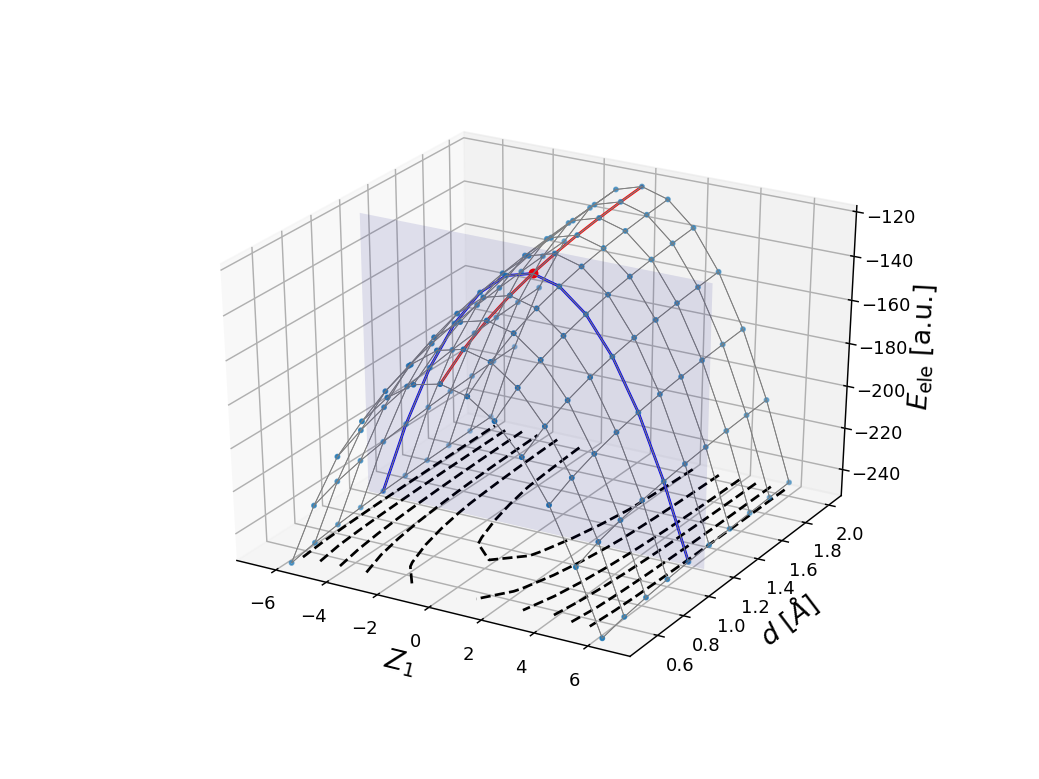

In [11]:
E_zr(data_N2_ZR)

# Full scan test runs

## inline horton run and/or generate Gaussian input files for production data
perform cheap calculation and save to npz file for post analysis

In [70]:
# cut = 3
# ref_d = 1.1
# Z_A_full = range(1, 14)[cut:-cut]
# Z_B_full = deepcopy(Z_A_full)
# Z_B_full.reverse()

# mols_full = []
# inps_full = []
# for Z1 in Z_A_full:
#     for Z2 in Z_B_full:
#         #print "processing (%d, %d)" % (Z1, Z2)
#         # choose d ~ N2 bond length of 1.0975
#         #d = 1.1
#         d = ref_d
#         mol = qtk.Molecule()
#         mol.build([[Z1,0,0,0], [Z2,d,0,0]])
#         mol.name = mol.name + '_%02d_%02d' % (Z1, Z2)
#         # construct horton input object 
#         # and compute AO integrals for initialization
#         mol.charge = Z1 + Z2 - 14
#         #job = qtk.QMInp(mol, **qmsetting_test)
#         #job = qtk.QMInp(mol, **qmsetting_production)
#         job = qtk.QMInp(mol, **qmsetting_production_ccsdt)
#         inps_full.append(job)
#         mols_full.append(mol)
# print "all done"

In [71]:
# qtk.qmWriteAll(inps_full, 'N2_production_run')
# qtk.qmWriteAll(inps_full, 'N2_production_ccsd_run')
#qtk.qmWriteAll(inps_full, 'N2_production_ccsdt_run')

In [72]:
# # do SCF for all molecules
# for mol in mols_full:
#     #print "processing (%d, %d)" % (mols[0].molecule.Z[0], mols[0].molecule.Z[1])
#     try:
#         mol.run()
#     except:
#         print mol.molecule.Z, mol.molecule.R[1]
#         mol.Et = 0.
# print "all done"

In [73]:
# # convert molecule data to unified interface

# dZ = []
# E = []
# for mol in mols_full:
#     x, y, z = mol.molecule.Z[0] - 7, mol.molecule.Z[1] - 7, mol.Et - mol.nn
#     dZ.append([x, y])
#     E.append(z)

# dZ = np.array(dZ)
# E = np.array(E)
# np.savez('data_N2_sto3g.npz', dZ=dZ, E=E)

# Prodectoin data extraction

In [74]:
# from glob import glob
# import os

# outs = []
# for f in sorted(glob('N2_production_ccsd_run/*/*.out')):
#     outs.append(qtk.QMOut(f, program='gaussian'))

# dZ = []
# E = []
# for out in outs:
#     _, Z1, Z2 = os.path.splitext(out.name)[0].split('_')
#     dZ.append([int(Z1) - 7, int(Z2) - 7])
#     E.append(out.Et - out.nuclear_repulsion)
# dZ = np.array(dZ)
# E = np.array(E)
# np.savez('data_N2_ccsd.npz', E=E, dZ=dZ)

## Unified analysis interface for external data (npz)
* Alchemical estimate data for surface data points: dZ matrix and E (dE) vector with corresponding indexing
* True surface data points: dZ matrix and E (dE) vector
* Higher orders along each eigenvector: 6 points of fractional nuclear charges and the corresponding dE for each eigenvector

In [75]:
#data_N2 = np.load('data_N2_sto3g.npz')
data_N2 = np.load('data_N2_production.npz')
#data_N2 = np.load('data_N2_ccsd.npz')

In [22]:
dZ, E = data_N2['dZ'], data_N2['E']
dZ1 = sorted(set(dZ[:,0]))
dZ2 = sorted(set(dZ[:,1]))
X, Y = np.meshgrid(dZ1, dZ2, indexing='ij')
E_mesh = np.zeros(X.shape)
for s, e in enumerate(E):
    i = dZ1.index(dZ[s][0])
    j = dZ1.index(dZ[s][1])
    E_mesh[i,j] = e

In [23]:
full_surface_data = []
line_mode1 = []
line_mode2 = []
ref_point = None
ref_point_2 = []

for x, y, z in zip(X.ravel(), Y.ravel(), E_mesh.ravel()):
    
    # scatter plot data
    if (abs(x) < 1E-5) and (abs(y) < 1E-5):
        ref_point = [x, y, z]
    else:
        full_surface_data.append([x, y, z])
    if x * y == 0 and ((x+y == -1) or (x+y == 1)):
        ref_point_2.append([x,y,z])
    
    
    # normal mode lines
    if abs(x + y) < 1E-5: # dZ1 + dZ2 = 0, mode1
        line_mode1.append([x, y, z])
    elif x == y: # dZ1 == dZ2, mode2
        line_mode2.append([x, y, z])

In [25]:
line_mode1 = np.array(line_mode1)
line_mode2 = np.array(line_mode2)
ref_point_2 = np.array(ref_point_2)

x1, y1, z1 = line_mode1.T[0], line_mode1.T[1], line_mode1.T[2]
x2, y2, z2 = line_mode2.T[0], line_mode2.T[1], line_mode2.T[2]
#300 represents number of points to make between T.min and T.max
x1new = np.linspace(x1.min(),x1.max(),100)
#z1new = interp1d(x1, z1, kind='cubic')
z1new = UnivariateSpline(x1, z1)

# contour plot data
full_surface_data = np.array(full_surface_data)
fdt = full_surface_data.T
x, y, z = full_surface_data.T[0], full_surface_data.T[1], full_surface_data.T[2]
xs = sorted(list(set(x)))
ys = sorted(list(set(y)))
X, Y = np.meshgrid(xs, ys, indexing='ij')
Z = E_mesh.copy()
    
xp = sorted(list(set(x1)))
yp = sorted(list(set(y1)))[::-1]
zlim = [-200,-20]
Xp, Yp = np.meshgrid(
    np.linspace(xp[0], xp[-1], 2, endpoint=True),
    np.linspace(yp[0], yp[-1], 2, endpoint=True),
    indexing='ij',
)
Xp, Zp = np.meshgrid(
    np.linspace(xp[0], xp[-1], 2, endpoint=True),
    np.linspace(zlim[0], zlim[1], 2, endpoint=True), 
)

x1_2d = deepcopy(x1).tolist()
z1_2d = deepcopy(z1).tolist()
x1_2d.pop(3)
z1_2d.pop(3)

-85.69545190447273

In [49]:
######################################
# first and second order derivatives #
######################################

# derivatives on fitted curve
d2E_N2 = z1new.derivative(n=2)(0)
d1E_N2 = z1new.derivative(n=1)(0)
d2E_BF = z1new.derivative(n=2)(-2)
d1E_BF = z1new.derivative(n=1)(-2)
d2E_CO = z1new.derivative(n=2)(-1)
d1E_CO = z1new.derivative(n=1)(-1)

# derivatives from data

In [65]:
##############################
# error data with dZ = +1/-1 #
##############################

# fake data for pipelining figure
err_N2 = np.random.random(4) - 0.5
err_CO = np.random.random(4) - 0.5

# real data

In [66]:
def interpolate12(d1E, d2E, x, y, dx):
    y_1st = y(dx) + (x - dx) * d1E
    y_2nd = y_1st + 0.5 * (x - dx)**2 * d2E
    return y_1st, y_2nd

z1N2_1st, z1N2_2nd = interpolate12(d1E_N2, d2E_N2, x1new, z1new, 0)
z1BF_1st, z1BF_2nd = interpolate12(d1E_BF, d2E_BF, x1new, z1new, -2)
z1CO_1st, z1CO_2nd = interpolate12(d1E_CO, d2E_CO, x1new, z1new, -1)

<IPython.core.display.Javascript object>


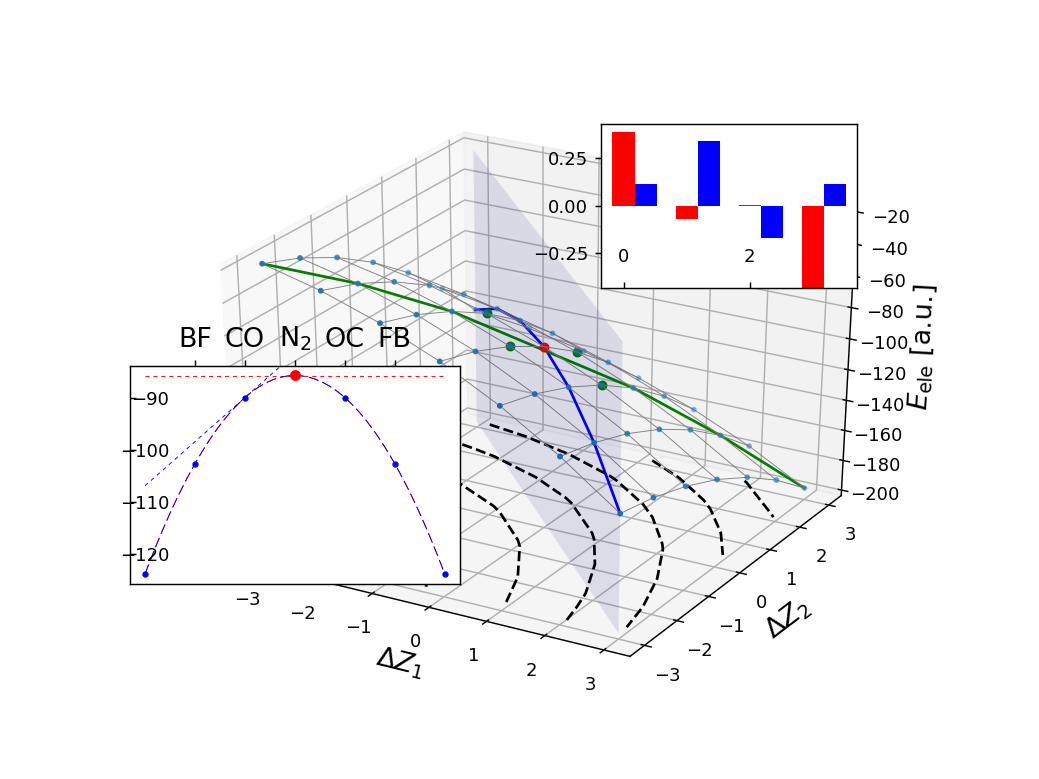

In [69]:
###############
# plot figure #
###############
    
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

######################
# energy curve inset #
######################
ax_inset = fig.add_subplot(223)
inset_pos = ax_inset.get_position().get_points()
inset_xlim = inset_pos[:,0].tolist()
inset_ylim = inset_pos[:,1].tolist()
inset_width = inset_xlim[1] - inset_xlim[0]
inset_height = inset_ylim[1] - inset_ylim[0]
ax_inset.set_position([inset_xlim[0], 0.14+inset_ylim[0], inset_width*0.9, inset_height*0.8])
ax_inset.xaxis.set_label_position('top')
ax_inset.xaxis.tick_top()
#ax_inset.tick_params(axis="x",direction="in", pad=-22)
ax_inset.tick_params(axis="y",direction="in", pad=-22)
#ax_inset.plot(x1new, z1new(x1new), color='b', zorder=0)
ax_inset.plot(x1_2d, z1_2d, color='b', ls='', marker='o', ms=2.5)
ax_inset.plot(x1new, z1N2_2nd, ls='--', color='r', zorder=0, lw=0.5)
ax_inset.plot(x1new, z1N2_1st, ls=':', color='r', zorder=0, lw=0.5)
inset_ylim = ax_inset.get_ylim()
ax_inset.plot(x1new, z1CO_2nd, ls='--', color='b', zorder=0, lw=0.5)
ax_inset.plot(x1new, z1CO_1st, ls=':', color='b', zorder=0, lw=0.5)
ax_inset.set_xticks(np.arange(-2, 3))
#labels = [item.get_text() for item in ax_inset.get_xticklabels()]
#labels[1] ='test'
labels = ['BF', 'CO', r'N$_2$', 'OC', 'FB']
ax_inset.set_xticklabels(labels, fontsize=15)
ax_inset.plot([x1[3]], [z1[3]], color='r', marker='o', ms=5)
ax_inset.set_ylim(inset_ylim)

###############
# error inset #
###############
ax_err = fig.add_subplot(222)
err_pos = ax_err.get_position().get_points()
err_xlim = err_pos[:,0].tolist()
err_ylim = err_pos[:,1].tolist()
err_width = err_xlim[1] - err_xlim[0]
err_height = err_ylim[1] - err_ylim[0]
ax_err.set_position([err_xlim[0]+0.03, err_ylim[0]+0.1, err_width*0.7, err_height*0.6])
ax_err.tick_params(axis="x",direction="in", pad=-22)
#ax_err.tick_params(axis="y",direction="in", pad=-22)
# ax_err.plot(err_N2)
# ax_err.plot(err_CO)
width = 0.35
ax_err.bar(np.arange(4), err_N2, width, color='r')
ax_err.bar(np.arange(4)+width, err_CO, width, color='b')

##################
# main 3D figure #
##################
ax.plot_wireframe(X,Y,Z, color='0.5', linewidth=0.5)
ax.set_xlabel(r'$\Delta Z_1$', fontsize=15)
ax.set_ylabel(r'$\Delta Z_2$', fontsize=15)
ax.set_zlabel(r'$E_{\rm ele}$ [a.u.]', fontsize=15)
ax.scatter(x, y, z, s=5)
ax.contour(X, Y, Z, zdir='z', offset=zlim[0], colors='black')

ax.plot(x1, y1, z1, c='blue')
ax.plot(x2, y2, z2, c='green')
ax.scatter([ref_point[0]], [ref_point[1]], [ref_point[2]], c='red', zorder=100)
s = ax.scatter([ref_point_2.T[0]], [ref_point_2.T[1]], [ref_point_2.T[2]], c='green')
s.set_edgecolors = s.set_facecolors = lambda *args:None
ax.set_zlim(zlim)
ax.plot_surface(Xp, Yp, Zp, alpha=0.1, color='blue')

# Modulize figure insets

In [79]:
def E_zz(data_N2, ax=None):
    
    if ax is None:
        fig = plt.figure(figsize=(8,6))
        ax = fig.add_subplot(111, projection='3d')

    ################
    # process data #
    ################
    dZ, E = data_N2['dZ'], data_N2['E']
    dZ1 = sorted(set(dZ[:,0]))
    dZ2 = sorted(set(dZ[:,1]))
    X, Y = np.meshgrid(dZ1, dZ2, indexing='ij')
    E_mesh = np.zeros(X.shape)
    for s, e in enumerate(E):
        i = dZ1.index(dZ[s][0])
        j = dZ1.index(dZ[s][1])
        E_mesh[i,j] = e

    ##############################
    # construct 3d plot elements #
    ##############################
    full_surface_data = []
    line_mode1 = []
    line_mode2 = []
    ref_point = None
    ref_point_2 = []

    for x, y, z in zip(X.ravel(), Y.ravel(), E_mesh.ravel()):

        # scatter plot data
        if (abs(x) < 1E-5) and (abs(y) < 1E-5):
            ref_point = [x, y, z]
        else:
            full_surface_data.append([x, y, z])
        if x * y == 0 and ((x+y == -1) or (x+y == 1)):
            ref_point_2.append([x,y,z])


        # normal mode lines
        if abs(x + y) < 1E-5: # dZ1 + dZ2 = 0, mode1
            line_mode1.append([x, y, z])
        elif x == y: # dZ1 == dZ2, mode2
            line_mode2.append([x, y, z])

    line_mode1 = np.array(line_mode1)
    line_mode2 = np.array(line_mode2)
    ref_point_2 = np.array(ref_point_2)

    x1, y1, z1 = line_mode1.T[0], line_mode1.T[1], line_mode1.T[2]
    x2, y2, z2 = line_mode2.T[0], line_mode2.T[1], line_mode2.T[2]
    #300 represents number of points to make between T.min and T.max
    x1new = np.linspace(x1.min(),x1.max(),100)
    #z1new = interp1d(x1, z1, kind='cubic')
    z1new = UnivariateSpline(x1, z1)

    #####################
    # contour plot data #
    #####################
    full_surface_data = np.array(full_surface_data)
    fdt = full_surface_data.T
    x, y, z = full_surface_data.T[0], full_surface_data.T[1], full_surface_data.T[2]
    xs = sorted(list(set(x)))
    ys = sorted(list(set(y)))
    X, Y = np.meshgrid(xs, ys, indexing='ij')
    Z = E_mesh.copy()

    xp = sorted(list(set(x1)))
    yp = sorted(list(set(y1)))[::-1]
    zlim = [-200,-20]
    Xp, Yp = np.meshgrid(
        np.linspace(xp[0], xp[-1], 2, endpoint=True),
        np.linspace(yp[0], yp[-1], 2, endpoint=True),
        indexing='ij',
    )
    Xp, Zp = np.meshgrid(
        np.linspace(xp[0], xp[-1], 2, endpoint=True),
        np.linspace(zlim[0], zlim[1], 2, endpoint=True), 
    )

    x1_2d = deepcopy(x1).tolist()
    z1_2d = deepcopy(z1).tolist()
    x1_2d.pop(3)
    z1_2d.pop(3)
    
    
    ##################
    # main 3D figure #
    ##################
    # surface
    ax.plot_wireframe(X,Y,Z, color='0.5', linewidth=0.5)          
    # grid points
    ax.scatter(x, y, z, s=5)                                      
    # underlieing contour
    ax.contour(X, Y, Z, zdir='z', offset=zlim[0], colors='black') 
    # eigenmode 1
    ax.plot(x1, y1, z1, c='blue')  
    # eigenmode 2
    ax.plot(x2, y2, z2, c='green') 
    # N2 base molecule
    ax.scatter([ref_point[0]], [ref_point[1]], [ref_point[2]], c='red', zorder=100)
    # CN, NO off diagonal molecule
    s = ax.scatter([ref_point_2.T[0]], [ref_point_2.T[1]], [ref_point_2.T[2]], c='green')
    s.set_edgecolors = s.set_facecolors = lambda *args:None # turning off depth transparency
    
    ax.set_xlabel(r'$\Delta Z_1$', fontsize=15)
    ax.set_ylabel(r'$\Delta Z_2$', fontsize=15)
    ax.set_zlabel(r'$E_{\rm ele}$ [a.u.]', fontsize=15)
    ax.set_zlim(zlim)
    ax.plot_surface(Xp, Yp, Zp, alpha=0.1, color='blue')

<IPython.core.display.Javascript object>


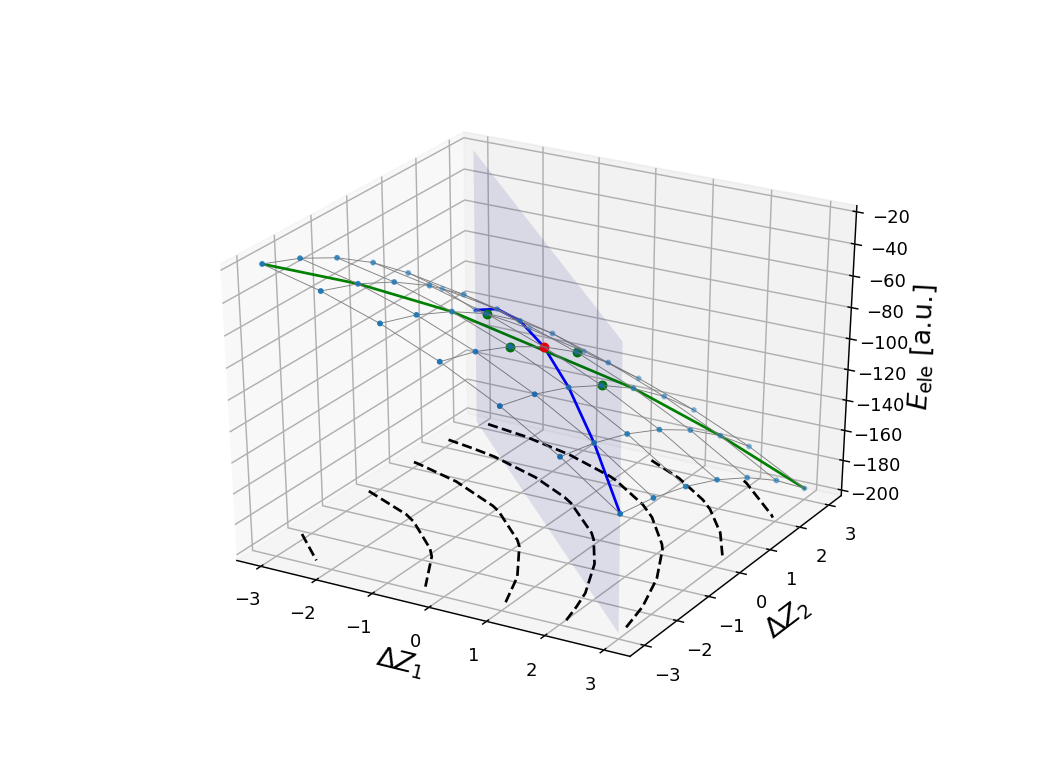

In [80]:
E_zz(data_N2)

In [ ]:
def E_eig1(data, ax=None):
    

# Third and fourth order error estimate
* __Goal__: Use least square fit of the third order and fourth order polynomial surfaces onto the true electronic energy surface to estimate how much the higher order contributions. 
* __Results__: Second order estimates gives the error around $\pm 1$ Hartree, while third order estimates gives the error around $\pm 0.3$ Hartree. However, fourth order fit gives singular matrix and is therefore not solvable at this moment.

<IPython.core.display.Javascript object>


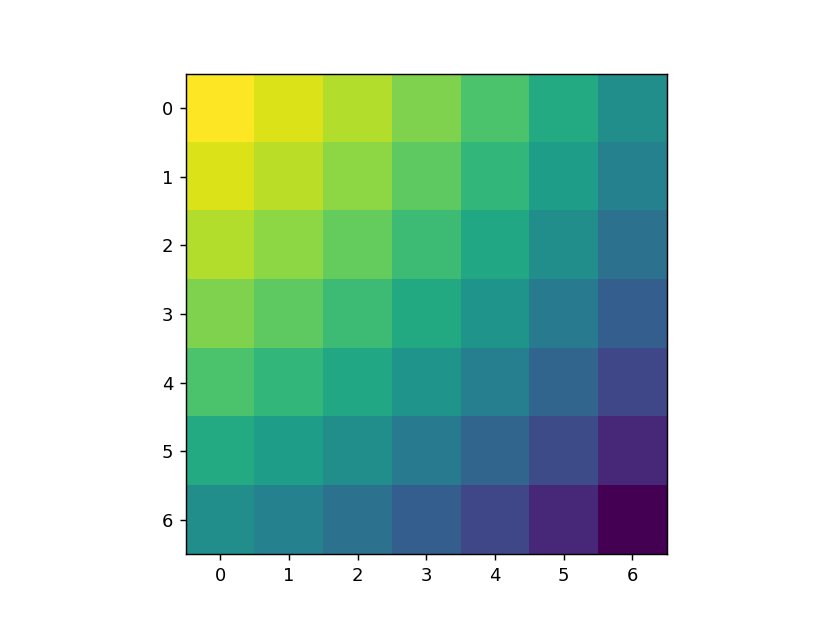

In [7]:
plt.figure()
plt.imshow(Z)

## First order least square fit

In [8]:
dZ1 = np.arange(-3, 4)
dZ2 = np.arange(-3, 4)
DZ1, DZ2 = np.meshgrid(dZ1, dZ2, indexing='ij')

In [9]:
DZ1

array([[-3, -3, -3, -3, -3, -3, -3],
       [-2, -2, -2, -2, -2, -2, -2],
       [-1, -1, -1, -1, -1, -1, -1],
       [ 0,  0,  0,  0,  0,  0,  0],
       [ 1,  1,  1,  1,  1,  1,  1],
       [ 2,  2,  2,  2,  2,  2,  2],
       [ 3,  3,  3,  3,  3,  3,  3]])

In [10]:
def l2_fit(X, Y, get_coefficents=False):
    """
    Y = X.dot(beta) + epsilon
    absorb constant epsilon in to X, rename beta and epsilon to w
    Y = X.dot(w)
    or
    Yi = Xi.T * wi + w0 for all i
    """
    X = np.asarray(X)
    X_base = X.copy()
    try:
        ones = np.ones(X.shape[-1])
        X = np.vstack([ones, X]).T
        #w = np.linalg.solve(np.dot(X.T, X), np.dot(X.T, Y))
        XTX_inv = np.linalg.inv(X.T.dot(X))
        w = XTX_inv.dot(X.T.dot(Y))
    except ValueError as err:
        qtk.warning('error with solve linear system: ' + str(err))
        qtk.warning('attempt transpose matrix X')
        X = X_base.T
        ones = np.ones(X.shape[-1])
        X = np.vstack([ones, X]).T
        w = np.linalg.solve(np.dot(X.T, X), np.dot(X.T, Y))
    except np.linalg.linalg.LinAlgError as err:
        qtk.warning('error with solve linear system: ' + str(err))
        qtk.warning('attemp to solve minimum norm')
        XXT_inv = np.linalg.inv(X.dot(X.T))
        w = X.T.dot(XXT_inv).dot(Y)
    if not get_coefficents:
        return np.dot(X, w)
    else:
        return np.dot(X, w), w

In [11]:
X_D1 = np.array([
    DZ1.ravel(),
    DZ2.ravel()
]).T
Z_D1 = l2_fit(X_D1.T, Z.ravel()).reshape(Z.shape)

<IPython.core.display.Javascript object>


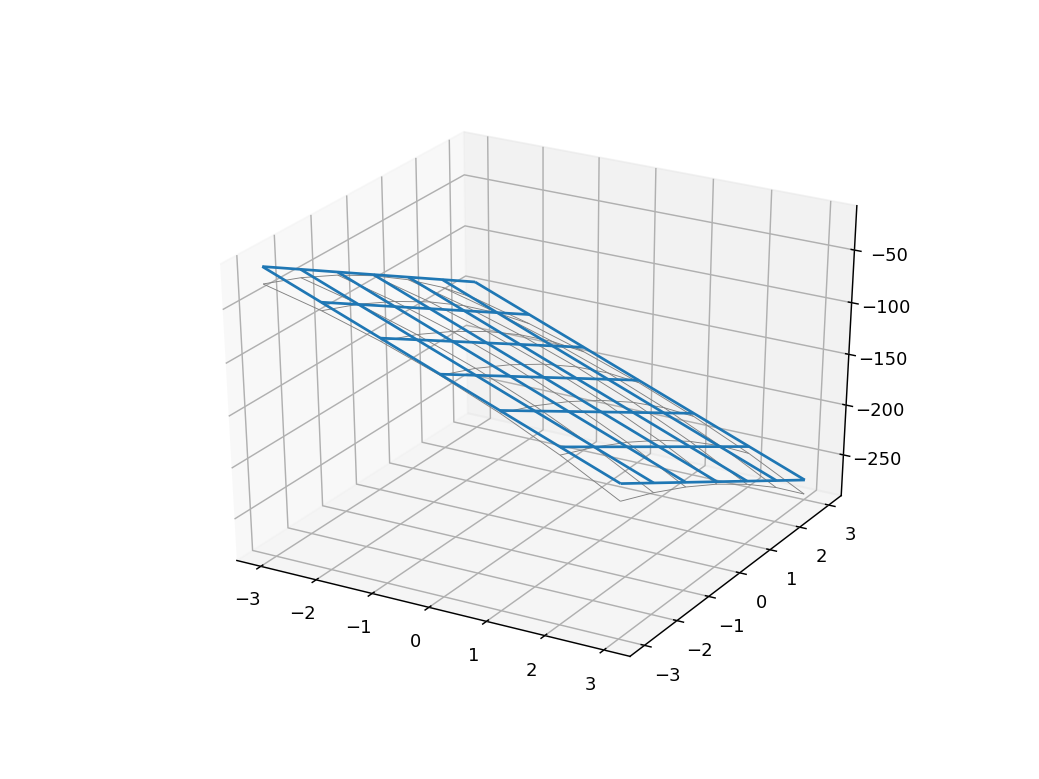

In [12]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(X,Y,Z_D1)
ax.plot_wireframe(X,Y,Z,color='0.5', linewidth=0.5)

## second order least square fit

In [16]:
dZ1Z2 = []
for dz1 in dZ1:
    for dz2 in dZ2:
        dZ1Z2.append(dz1 * dz2)
dZ1Z2 = np.array(dZ1Z2)
DZ1Z2 = dZ1Z2.reshape(Z.shape)
DZ1Z1, DZ2Z2 = np.meshgrid(dZ1 ** 2, dZ2 ** 2, indexing='ij')

In [17]:
X_D2 = np.array([
    DZ1.ravel(),
    DZ2.ravel(),
    DZ1Z1.ravel(),
    DZ1Z2.ravel(),
    DZ2Z2.ravel()
]).T
Z_D2 = qtk.ML.l2_fit(X_D2.T, Z.ravel()).reshape(Z.shape)

In [18]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(X,Y,Z_D2)
ax.plot_wireframe(X,Y,Z,color='0.5', linewidth=0.5)

<IPython.core.display.Javascript object>

In [19]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(X,Y,Z_D2 - Z)
plt.figure()
plt.imshow(Z_D2 - Z)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## third order least square fit

In [20]:
DZ1Z1Z1, DZ2Z2Z2 = np.meshgrid(dZ1 ** 3, dZ2 ** 3, indexing='ij')
dZ1Z1Z2, dZ1Z2Z2 = [], []
for dz1 in dZ1:
    for dz2 in dZ2:
        dZ1Z1Z2.append(dz1 * dz1 * dz2)
        dZ1Z2Z2.append(dz1 * dz2 * dz2)
dZ1Z1Z2 = np.array(dZ1Z1Z2)
dZ1Z2Z2 = np.array(dZ1Z2Z2)
DZ1Z1Z2 = dZ1Z1Z2.reshape(Z.shape)
DZ1Z2Z2 = dZ1Z2Z2.reshape(Z.shape)

In [21]:
X_D3 = np.array([
    DZ1.ravel(),
    DZ2.ravel(),
    DZ1Z1.ravel(),
    DZ1Z2.ravel(),
    DZ2Z2.ravel(),
    DZ1Z1Z1.ravel(),
    DZ1Z1Z2.ravel(),
    DZ1Z2Z2.ravel(),
    DZ2Z2Z2.ravel(),
]).T
Z_D3 = l2_fit(X_D3, Z.ravel()).reshape(Z.shape)

error with solve linear system: Singular matrix
attemp to solve minimum norm


ValueError: shapes (50,9) and (49,) not aligned: 9 (dim 1) != 49 (dim 0)

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(X,Y,Z_D2)
ax.plot_wireframe(X,Y,Z,color='0.5', linewidth=0.5)

### Error compared to true surface

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(X,Y,Z_D3 - Z)
plt.figure()
plt.imshow(Z_D3 - Z)

### error compared to second order surface

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(X,Y,Z_D3 - Z_D2)
plt.figure()
plt.imshow(Z_D3 - Z_D2)

In [ ]:
eZ_D3 = Z - Z_D3
eZ_D2 = Z - Z_D2
plt.figure()
plt.plot(eZ_D3.ravel(), eZ_D2.ravel(), ls='', marker='o')

## fourth order least square fit

In [ ]:
DZ1Z1Z1Z1, DZ2Z2Z2Z2 = np.meshgrid(dZ1 ** 4, dZ2 ** 4, indexing='ij')
dZ1Z1Z1Z2, dZ1Z1Z2Z2, dZ1Z2Z2Z2 = [], [], []
for dz1 in dZ1:
    for dz2 in dZ2:
        dZ1Z1Z1Z2.append(dz1 * dz1 * dz1 * dz2)
        dZ1Z1Z2Z2.append(dz1 * dz1 * dz2 * dz2)
        dZ1Z2Z2Z2.append(dz1 * dz2 * dz2 * dz2)
dZ1Z1Z1Z2 = np.array(dZ1Z1Z1Z2)
dZ1Z1Z2Z2 = np.array(dZ1Z1Z2Z2)
dZ1Z2Z2Z2 = np.array(dZ1Z2Z2Z2)
DZ1Z1Z1Z2 = dZ1Z1Z1Z2.reshape(Z.shape)
DZ1Z1Z2Z2 = dZ1Z1Z2Z2.reshape(Z.shape)
DZ1Z2Z2Z2 = dZ1Z2Z2Z2.reshape(Z.shape)

In [ ]:
X_D4 = np.array([
    DZ1.ravel(),
    DZ2.ravel(),
    DZ1Z1.ravel(),
    DZ1Z2.ravel(),
    DZ2Z2.ravel(),
    DZ1Z1Z1.ravel(),
    DZ1Z1Z2.ravel(),
    DZ1Z2Z2.ravel(),
    DZ2Z2Z2.ravel(),
    DZ1Z1Z1Z1.ravel(),
    DZ1Z1Z1Z2.ravel(),
    DZ1Z1Z2Z2.ravel(),
    DZ1Z2Z2Z2.ravel(),
    DZ2Z2Z2Z2.ravel(),
]).T
Z_D4 = l2_fit(X_D4.T, Z.ravel()).reshape(Z.shape)

In [ ]:
X_D4.shape

In [ ]:
_X = X_D4
print _X.shape
print np.linalg.matrix_rank(_X)

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(X,Y,Z_D4)
ax.plot_wireframe(X,Y,Z,color='0.5', linewidth=0.5)

# Error estimate using surface span by data points along normal modes

In [ ]:
Xn, Yn, Zn = [], [], []
n_points = 7/2
for i in range(n_points):
    j = n_points - i - 1
    xn1, yn1, zn1 = X[i,i] - 7, Y[i,i] - 7, Z[i,i]
    xn2, yn2, zn2 = X[i,j] - 7, Y[i,j] - 7, Z[i,j]
    if xn1 == 0 and xn2 == 0:
        Xn.append(xn1)
        Yn.append(yn1)
        Zn.append(zn1)
    else:
        Xn.append(xn1)
        Xn.append(xn2)
        Yn.append(yn1)
        Yn.append(yn2)
        Zn.append(zn1)
        Zn.append(zn2)
Xn = np.array(Xn)
Yn = np.array(Yn)
Zn = np.array(Zn)

In [ ]:
Yn

In [ ]:
Xn_D2 = np.array([
    Xn,
    Yn,
    Xn ** 2,
    Xn * Yn,
    Yn ** 2,
]).T

In [ ]:
Xn_D2

In [ ]:
Yn

In [ ]:
print Xn_D2.shape
print np.linalg.matrix_rank(Xn_D2)

In [ ]:
Zn_D2_lim, w_D2 = qtk.ML.l2_fit(Xn_D2.T, Zn, get_coefficents=True)

In [ ]:
w_D2

In [ ]:
def Z_fit(X, Y, w):
    return (X-7) * w[-1] + (Y-7) * w[-2] + (X-7)**2 * w[-3]/2 + (Y-7)*(X-7) * w[-4] + (Y-7)**2 * w[-3]/2 + w[-5]

In [ ]:
Zn_D2 = Z_fit(X, Y, w_D2)

In [ ]:
Zn_D2

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(X,Y,Zn_D2)
ax.plot_wireframe(X,Y,Z,color='0.5', linewidth=0.5)

# Horton second order estimate test

In [ ]:
for mol in mols_full:
    Z1, Z2 = mol.molecule.Z[0], mol.molecule.Z[1]
    if Z1 == 7 and Z2 == 7:
        mol_N2 = mol

In [ ]:
cache = mol_N2.ht_ham.cache
sorted(list(cache.iterkeys()))

In [ ]:
print cache['energy_libxc_gga_x_pbe'], cache['energy_libxc_gga_c_pbe']

In [ ]:
print mol_N2.ht_grid.integrate(cache['dpot_libxc_gga_x_pbe_alpha'])
print mol_N2.ht_grid.integrate(cache['dpot_libxc_gga_c_pbe_alpha'])
print mol_N2.ht_grid.integrate(cache['spot_libxc_gga_x_pbe_alpha'])
print mol_N2.ht_grid.integrate(cache['spot_libxc_gga_c_pbe_alpha'])

In [ ]:
mol_N2.ht_grid.integrate(mol_N2.vxc())